In [1]:
import sys

import numpy as np

from matplotlib import pyplot as plt, colors, cm, scale as mscale
from matplotlib.collections import LineCollection
import cmasher

from skimage.color import lab2rgb

from tqdm import tqdm

sys.path.append('..')
from sketched.sketched import DiscreteSpectrum, SketchedEquivalence, JointSketchingEquivalence

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

#color_cycle = ['#003366', '#990000', '#669900']
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

0.5 0.1 5.0


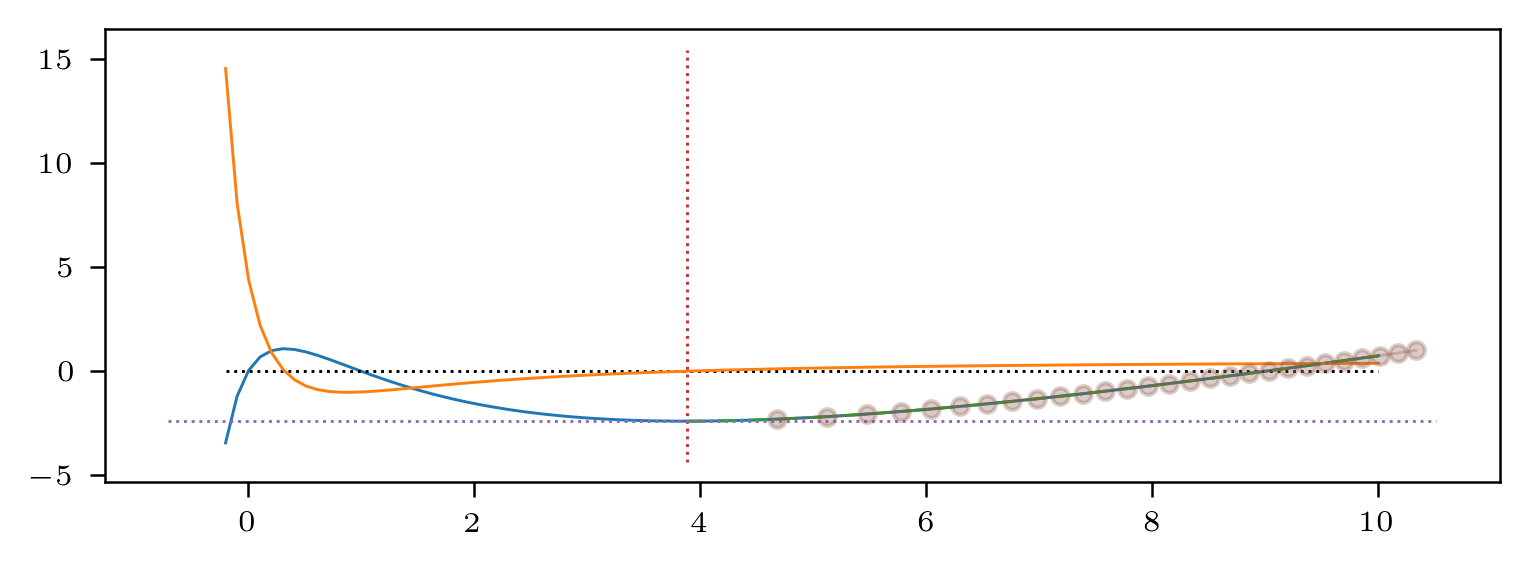

In [3]:
p = 100
n = 100
a = np.zeros(p)
a[:n] = 1
X = np.diag(a) * np.sqrt(n)

m = 10
q = 50

phi = q / m

def resolvent_by_m(mu):
    XHX = X.T @ X / n
    return np.trace(np.linalg.solve(XHX + mu * np.eye(p), XHX)) / m

def lamda_of_mu(mu):
    to_square = phi + 1 - 2 * resolvent_by_m(mu)
    return mu / (4 * phi) * (to_square ** 2 - (1 - phi) ** 2)

mus = np.linspace(-0.2, 10, 101)
lamdas = [lamda_of_mu(mu) for mu in mus]

plt.figure(dpi=300)

plt.plot(mus, lamdas)
plt.plot(mus, np.zeros_like(mus), ':k')
#plt.plot(mus[:-1], np.diff(lamdas))
#plt.plot(mus[:-1], np.zeros(99), ':k')

spectrum = DiscreteSpectrum([1, 0], [min(p / n, 1.0), 1 - min(p / n, 1.0)])
jse = JointSketchingEquivalence(spectrum, q / p, m / n, q / m)

ys = np.asarray([np.imag(lamda_of_mu(mu + 0.001j)) for mu in mus])
plt.plot(mus, 500 * ys)
lamdas_2 = [jse.get_lamda_from_mu(mu) for mu in mus]
plt.plot(mus, lamdas_2, '-.')
#plt.plot(mus, np.zeros(100), ':k')

plt.plot([jse.mu_0, jse.mu_0], plt.ylim(), ':')
plt.plot(plt.xlim(), [jse.lamda_0, jse.lamda_0], ':')

lams = np.linspace(-5, 1, 50)
mus_2 = [jse.get_mu_from_lamda(lamda) for lamda in lams]
plt.plot(mus_2, lams, marker='o', alpha=0.3)

print(q / p, m / n, q / m)

plt.show()

In [4]:
jse.get_mu_max(), jse.mu_0, jse.T_equiv.mu_0

(11.999999999999998, 3.8786233433677535, 2.162277660168265)

In [17]:
def compute_mu(spectrum, lamda, alpha, eta, phi):
    jse = JointSketchingEquivalence(spectrum, alpha, eta, phi)
    mu = jse.get_mu_from_lamda(lamda)
    if mu is None:
        return None
        print(lamda, alpha, eta, phi)
    return mu

lamdas = [0.001, 0.1, 10]
lamdas = [0.05, 0.5, 5, 50]
alphas = np.linspace(1e-2, 2, 50)
etas = np.linspace(1e-2, 2, 50)
p_ns = [0.5, 1, 2]

mus = np.zeros((len(lamdas), len(p_ns), len(alphas), len(etas)))

for k, lamda in enumerate(lamdas):
    for l, p_n in enumerate(p_ns):
        nonzero_val = max(p_n, 1.0)
        nonzero_frac = min(p_n, 1.0)
        spectrum = DiscreteSpectrum([nonzero_val, 0.0], [nonzero_frac, 1.0 - nonzero_frac])
        for i, alpha in enumerate(tqdm(alphas)):
            for j, eta in enumerate(etas):
                mus[k, l, i, j] = compute_mu(spectrum, lamda, alpha, eta, alpha * p_n / eta)

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.35it/s]


/tmp/ipykernel_12033/2010323657.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.5)


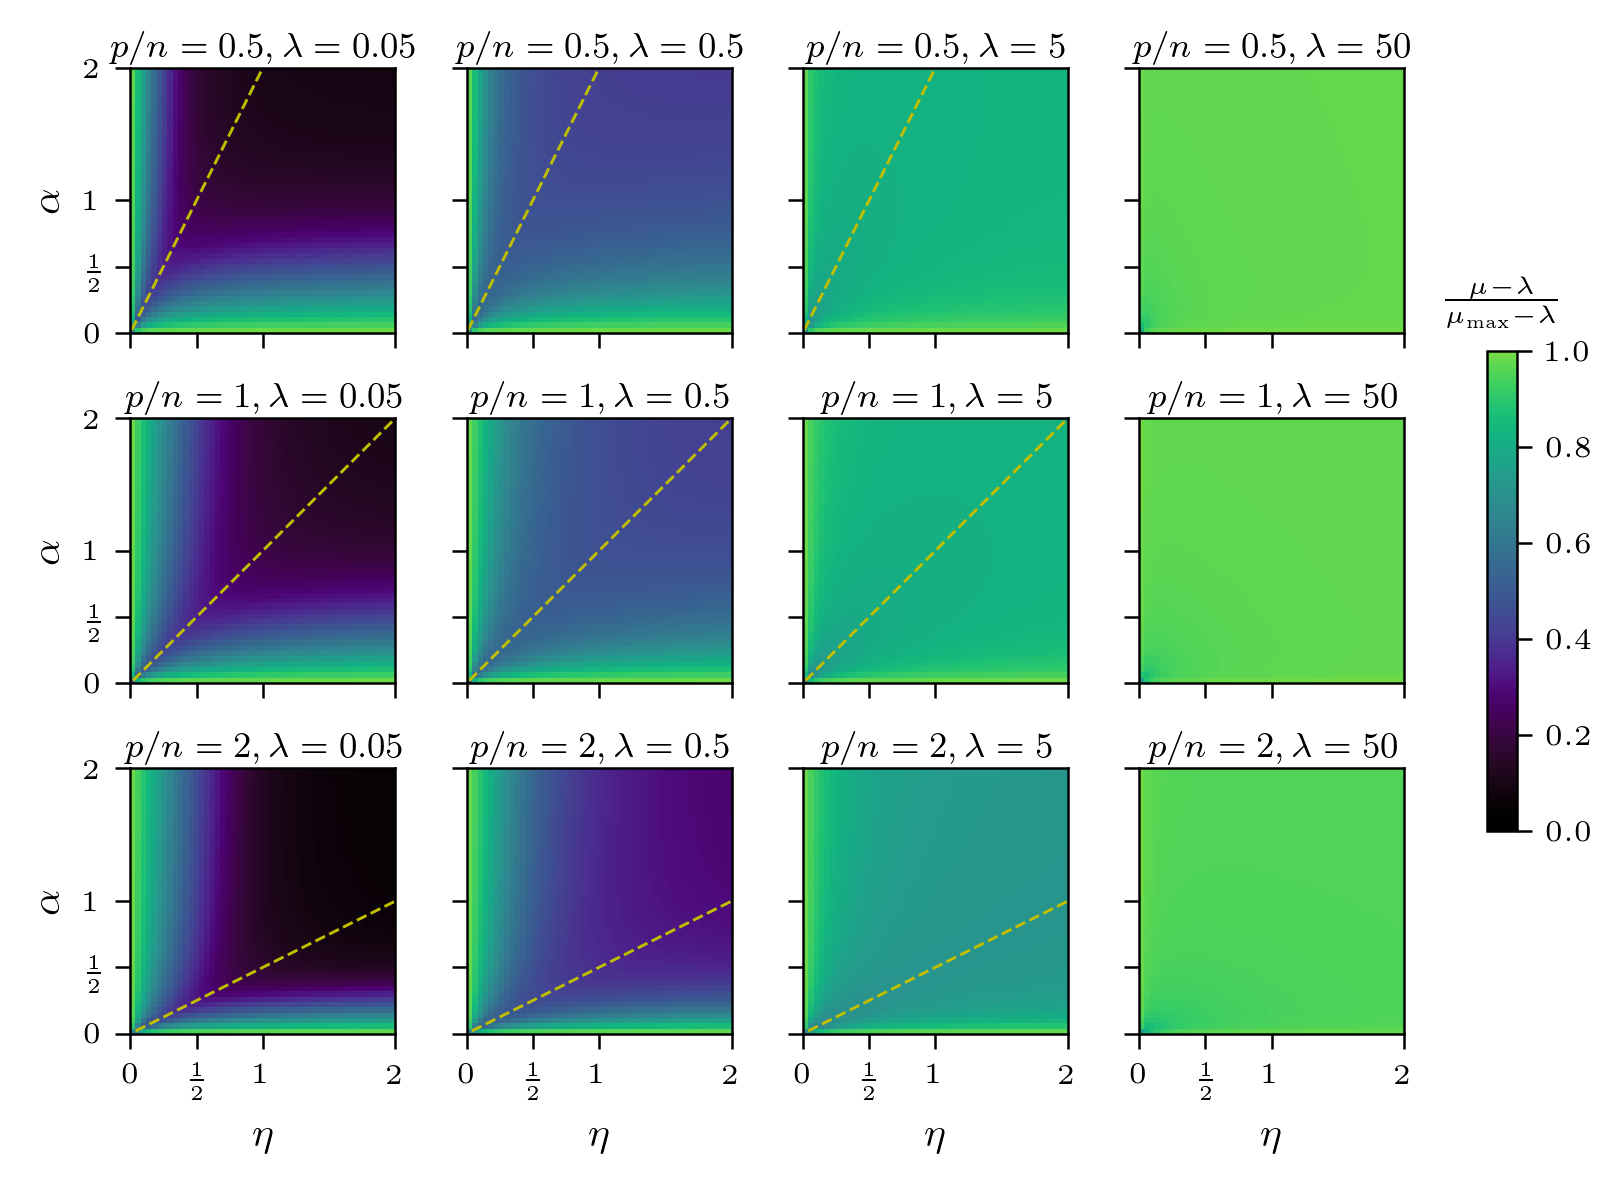

In [19]:
fig, axes = plt.subplots(3, 4, dpi=300, figsize=(5, 4), sharex='col', sharey='row')
ticks_values = np.asarray([0.0, 0.25, 0.5, 1.0]) * len(alphas) - 0.5
ticks_labels = [0, r'$\frac{1}{2}$', 1, 2]
cmap = cmasher.lavender

for k, lamda in enumerate(lamdas):
    for l, p_n in enumerate(p_ns):
        ax = axes[l, k]
        #plt.imshow(mus[k, :, :] / (lamda + 1 / alphas[:, None] + 1 / etas[None, :]))
        
        tr = p_n
        #mx = lamda + 1 / alphas[:, None] + 1 / etas[None, :]
        mx = lamda + (1 / alphas[:, None] / p_n + 1 / etas[None, :]) * tr
        mn = lamda
        
        ax.imshow(np.flip((mus[k, l, :, :] - mn) / (mx - mn), axis=0), vmin=0, vmax=1, cmap=cmap)
        ax.set_title(f'$p/n = {p_n:g}, \\lambda = {lamda:g}$')
        ax.set_yticks(49 - ticks_values, ticks_labels)
        ax.set_xticks(ticks_values, ticks_labels)
        
        if k == 0:
            ax.set_ylabel(r'$\alpha$')
        
        if k < 3:
            xlim, ylim = ax.get_xlim(), ax.get_ylim()
            xs = p_n * etas * len(alphas) - 0.5
            ys = (1 - alphas) * len(alphas) - 0.5
            ax.plot(xs, ys, '--y')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            
        if l == 2:
            ax.set_xlabel(r'$\eta$')

# colorbar
ax = fig.add_axes([1.01, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(0, 1), cmap=cmap), cax=ax)
ax.set_title(r'$\frac{\mu - \lambda}{\mu_{\max} - \lambda}$', pad=10)

plt.tight_layout(w_pad=0.5)
plt.savefig('mu_dual_sketch.pdf', bbox_inches='tight')
plt.show()

In [43]:
n = 500
p = 4000
m = 3000
q = 800

T = np.random.randn(n, m) / np.sqrt(m)
S = np.random.randn(p, q) / np.sqrt(q)

U, _, Vt = np.linalg.svd(np.random.randn(n, p), full_matrices=False)
D = np.eye(min(n, p)) * np.sqrt(max(n, p))
X = U @ D @ Vt

nonzero_val = max(p / n, 1.0)
nonzero_frac = min(p / n, 1.0)
sketched.BIGEPSILON = 1e-1
spectrum = DiscreteSpectrum([nonzero_val, 0.0], [nonzero_frac, 1.0 - nonzero_frac])
jse = JointSketchingEquivalence(spectrum, q / p, m / n, q / m)
jse.lamda_0

-0.27718693682564716

In [44]:
spectrum = DiscreteSpectrum([nonzero_val, 0.0], [nonzero_frac, 1.0 - nonzero_frac])
jse = JointSketchingEquivalence(spectrum, q / p, m / n, q / m)
jse.mu_0, jse.lamda_0

(-1.6288852041680062, -0.27718693682564716)

In [45]:
Z = T.T @ X @ S

A = Z.T @ Z / n

np.linalg.eigvalsh(A)[-min(m, q, n, p):][:5]

array([0.30814938, 0.33175972, 0.33673898, 0.34855647, 0.35391899])

In [10]:
T.shape, X.shape, S.shape

((1000, 500), (1000, 2000), (2000, 480))